In [2]:
pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [1]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict
from searchFoodImage import get_food_name_from_google
from FoodClassifer import classify_image_file
from FoodNutients import find_best_match, get_food_details, find_best_food_match
# from langchain_ollama import ChatOllama
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.runnables import RunnableLambda

# Define image path
image_path = "testingFood.webp"

# # LLMs
# llm = ChatOllama(model="llama3.1:8b")
# llm2 = ChatOllama(model="gemma3:4b")

# # Prompt to clean up food names
# query = """Extract name of given food array in one line
# FoodArray: {food_array}
# Answer:
# """
# prompt = ChatPromptTemplate.from_template(query)
# food_name_chain = prompt | llm2


Embeddings loaded successfully!


In [2]:
class GraphState(TypedDict):
    image_path: str
    classification: str
    raw_name: str
    food_name: str
    nutrition: dict


In [3]:
async def classify_image(state: GraphState):
    image_type = await classify_image_file(state["image_path"])
    return {"classification": image_type["prediction"]}

async def get_food_name(state: GraphState):
    if state["classification"] == "Food":
        name = get_food_name_from_google(state["image_path"])
    else:
        name = "Non-Food"
    return {"raw_name": name}

async def clean_food_name(state: GraphState):
    result = find_best_food_match(state["raw_name"])
    return {"food_name": result}

def get_nutrition(state: GraphState):
    if state["food_name"] != "Non-Food":
        info = get_food_details(state["food_name"])
    else:
        info = {}
    return {"nutrition": info}


In [6]:
builder = StateGraph(GraphState)

builder.add_node("classify", classify_image)
builder.add_node("get_name", get_food_name)
builder.add_node("clean_name", clean_food_name)
builder.add_node("get_nutrition", get_nutrition)

builder.set_entry_point("classify")

builder.add_edge("classify", "get_name")
builder.add_edge("get_name", "clean_name")
builder.add_edge("clean_name", "get_nutrition")
builder.add_edge("get_nutrition", END)

graph = builder.compile()


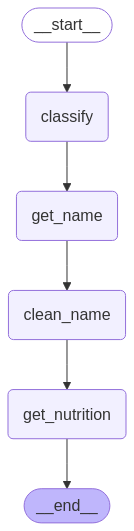

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
image_path = "test.jpg"
result = await graph.ainvoke({"image_path": image_path})
print(result)


{'image_path': 'test.jpg', 'classification': 'Food', 'raw_name': ['Samosa', 'Pea samosas', 'Aalu Samosa', 'Golden, flaky, and crispy Samosas are life! Make it today or save it for later. The recipe link in my bio @feastwithsafiya #feastwithsafiya #aloosamosa #samosay #samosa #samosas #samboosa #sambusa #sambusak #samusa #potatosamosa #', 'Priyanshu Kumar | Homemade Samosa with tangy green mango pudina chutney for snacks today. 😍😋 Made by sis @yogitagaharwar . Hand courtesy @akanksha_saha 😊... | Instagram', 'Farah (@farahskitchen23) • Instagram photos and videos', 'Sheenam & Muskaan | SAMOSA TIME😍😍😍 delicious crispy sweet potato samosas that are so yummy and so perfect for snacking 🤤 full recipe on the blog (link in bio)... | Instagram', 'Ramzan Special Recipes ll Iftar Snacks ll Aloo Kay Samosay Recipe by Noor kitchen ll Patato Snakes - YouTube'], 'food_name': 'vegetable samosas', 'nutrition': {'name': 'vegetable samosas', 'id': 257836, 'minutes': 25, 'contributor_id': 607647, 'submitt